In [1]:
%matplotlib inline

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.filterwarnings('ignore')
pd.options.display.max_columns = None

from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import StratifiedKFold
from sklearn.feature_selection import RFECV
from sklearn.model_selection import train_test_split

In [2]:
train = pd.read_csv("train.csv")
test = pd.read_csv("test.csv")
df=pd.concat([train, test], axis=0)
df.head()

,Unnamed: 0,id,Gender,Customer Type,Age,Type of Travel,Class,Flight Distance,Inflight wifi service,Departure/Arrival time convenient,Ease of Online booking,Gate location,Food and drink,Online boarding,Seat comfort,Inflight entertainment,On-board service,Leg room service,Baggage handling,Checkin service,Inflight service,Cleanliness,Departure Delay in Minutes,Arrival Delay in Minutes,satisfaction
0,0,70172,Male,Loyal Customer,13,Personal Travel,Eco Plus,460,3,4,3,1,5,3,5,5,4,3,4,4,5,5,25,18.0,neutral or dissatisfied
1,1,5047,Male,disloyal Customer,25,Business travel,Business,235,3,2,3,3,1,3,1,1,1,5,3,1,4,1,1,6.0,neutral or dissatisfied
2,2,110028,Female,Loyal Customer,26,Business travel,Business,1142,2,2,2,2,5,5,5,5,4,3,4,4,4,5,0,0.0,satisfied
3,3,24026,Female,Loyal Customer,25,Business travel,Business,562,2,5,5,5,2,2,2,2,2,5,3,1,4,2,11,9.0,neutral or dissatisfied
4,4,119299,Male,Loyal Customer,61,Business travel,Business,214,3,3,3,3,4,5,5,3,3,4,4,3,3,3,0,0.0,satisfied


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 129880 entries, 0 to 25975
Data columns (total 25 columns):
 #   Column                             Non-Null Count   Dtype  
---  ------                             --------------   -----  
 0   Unnamed: 0                         129880 non-null  int64  
 1   id                                 129880 non-null  int64  
 2   Gender                             129880 non-null  object 
 3   Customer Type                      129880 non-null  object 
 4   Age                                129880 non-null  int64  
 5   Type of Travel                     129880 non-null  object 
 6   Class                              129880 non-null  object 
 7   Flight Distance                    129880 non-null  int64  
 8   Inflight wifi service              129880 non-null  int64  
 9   Departure/Arrival time convenient  129880 non-null  int64  
 10  Ease of Online booking             129880 non-null  int64  
 11  Gate location                      12988

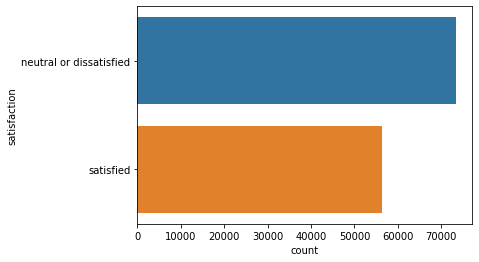

In [4]:
c_palette = ['tab:blue', 'tab:orange']
sns.countplot(data=df, y = 'satisfaction', palette=c_palette)

Pogledajmo koliko jedinstvenih vrijednosti ima svaki od naših kategorijalnih stupaca.

In [5]:
print ("Type of travel: ", df['Type of Travel'].unique())
print ("Class: ", df['Class'].unique())
print ("Gender: ", df['Gender'].unique())
print ("Customer Type: ", df['Customer Type'].unique())
print ("Satisfaction: ", df['satisfaction'].unique())

Type of travel:  ['Personal Travel' 'Business travel']
Class:  ['Eco Plus' 'Business' 'Eco']
Gender:  ['Male' 'Female']
Customer Type:  ['Loyal Customer' 'disloyal Customer']
Satisfaction:  ['neutral or dissatisfied' 'satisfied']


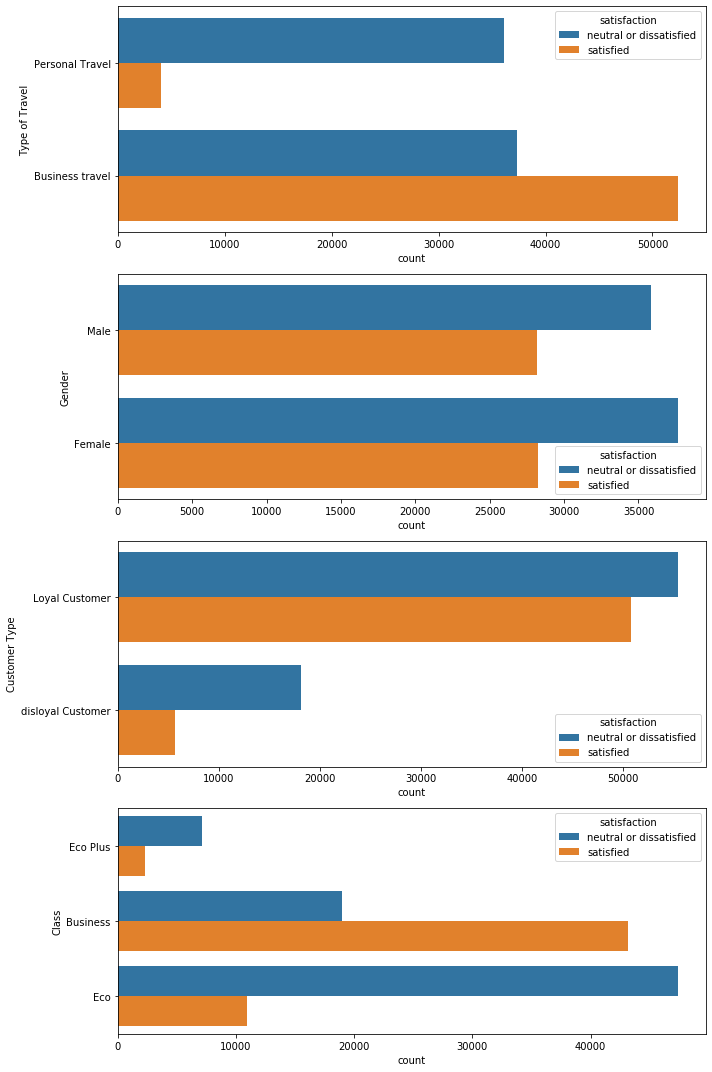

In [6]:
fig, axes = plt.subplots(nrows=4, figsize=(10,15))

sns.countplot(data=df, y = 'Type of Travel', hue='satisfaction', palette=c_palette, ax=axes[0])
sns.countplot(data=df, y = 'Gender', hue='satisfaction', palette=c_palette, ax=axes[1])
sns.countplot(data=df, y = 'Customer Type', hue='satisfaction', palette=c_palette, ax=axes[2])
sns.countplot(data=df, y = 'Class', hue='satisfaction', palette=c_palette, ax=axes[3])

fig.tight_layout()

Vidimo da nam ne treba stupac <code>Unnamed</code> koji je samo preslika indexa i stupac <code>id</code> koji je jedinstveni broj za svakog putnika. Također, pretvorimo kategorijalne varijable u intove.

In [7]:
df.drop(['Unnamed: 0', 'id'], axis=1, inplace=True)

gender_mapper = {'Male': 0, 'Female': 1}
df['Gender'].replace(gender_mapper, inplace=True)
type_mapper = {'Personal Travel': 0, 'Business travel': 1}
df['Type of Travel'].replace(type_mapper, inplace=True)
cust_mapper = {'Loyal Customer': 0, 'disloyal Customer': 1}
df['Customer Type'].replace(cust_mapper, inplace=True)
satisfaction_mapper = {'neutral or dissatisfied': 0, 'satisfied': 1}
df['satisfaction'].replace(satisfaction_mapper, inplace=True)

df.head()

,Gender,Customer Type,Age,Type of Travel,Class,Flight Distance,Inflight wifi service,Departure/Arrival time convenient,Ease of Online booking,Gate location,Food and drink,Online boarding,Seat comfort,Inflight entertainment,On-board service,Leg room service,Baggage handling,Checkin service,Inflight service,Cleanliness,Departure Delay in Minutes,Arrival Delay in Minutes,satisfaction
0,0,0,13,0,Eco Plus,460,3,4,3,1,5,3,5,5,4,3,4,4,5,5,25,18.0,0
1,0,1,25,1,Business,235,3,2,3,3,1,3,1,1,1,5,3,1,4,1,1,6.0,0
2,1,0,26,1,Business,1142,2,2,2,2,5,5,5,5,4,3,4,4,4,5,0,0.0,1
3,1,0,25,1,Business,562,2,5,5,5,2,2,2,2,2,5,3,1,4,2,11,9.0,0
4,0,0,61,1,Business,214,3,3,3,3,4,5,5,3,3,4,4,3,3,3,0,0.0,1


Provjerimo imamo li vrijednosti koje nedostaju i koliki je njihov postotak.

In [8]:
df.isnull().sum()/len(df)

Gender                               0.000000
Customer Type                        0.000000
Age                                  0.000000
Type of Travel                       0.000000
Class                                0.000000
Flight Distance                      0.000000
Inflight wifi service                0.000000
Departure/Arrival time convenient    0.000000
Ease of Online booking               0.000000
Gate location                        0.000000
Food and drink                       0.000000
Online boarding                      0.000000
Seat comfort                         0.000000
Inflight entertainment               0.000000
On-board service                     0.000000
Leg room service                     0.000000
Baggage handling                     0.000000
Checkin service                      0.000000
Inflight service                     0.000000
Cleanliness                          0.000000
Departure Delay in Minutes           0.000000
Arrival Delay in Minutes          

Dakle, samo u jednom stupcu imamo missing values i to jako mali postotak pa redove u kojima se nalaze možemo bez problema izbaciti.

In [9]:
df.dropna(axis=0,inplace=True)

Encodali smo sve kategorijalne vrijednosti osim onih u stupcu <code>Class</code> jer tamo imamo više od dvije. Budući da ne želimo nejednake težne, ovaj ćemo stupac One Hot Encodati.

In [10]:
df['Class'] = pd.Categorical(df['Class'])
dfDummies = pd.get_dummies(df['Class'], prefix = 'Class')
df = pd.concat([df, dfDummies], axis=1)
df.drop('Class', axis=1, inplace=True)

Rješavanje koreliranih featurea:

In [11]:
correlated_features = set()
correlation_matrix = df.drop('satisfaction', axis=1).corr()

for i in range(len(correlation_matrix.columns)):
    for j in range(i):
        if abs(correlation_matrix.iloc[i, j]) > 0.8:
            colname = correlation_matrix.columns[i]
            correlated_features.add(colname)
            
correlated_features

{'Arrival Delay in Minutes', 'Class_Eco'}

In [12]:
df.drop(correlated_features, axis=1, inplace=True)

In [13]:
df1 = df.pop('satisfaction')
df['satisfaction']=df1
df.head()

,Gender,Customer Type,Age,Type of Travel,Flight Distance,Inflight wifi service,Departure/Arrival time convenient,Ease of Online booking,Gate location,Food and drink,Online boarding,Seat comfort,Inflight entertainment,On-board service,Leg room service,Baggage handling,Checkin service,Inflight service,Cleanliness,Departure Delay in Minutes,Class_Business,Class_Eco Plus,satisfaction
0,0,0,13,0,460,3,4,3,1,5,3,5,5,4,3,4,4,5,5,25,0,1,0
1,0,1,25,1,235,3,2,3,3,1,3,1,1,1,5,3,1,4,1,1,1,0,0
2,1,0,26,1,1142,2,2,2,2,5,5,5,5,4,3,4,4,4,5,0,1,0,1
3,1,0,25,1,562,2,5,5,5,2,2,2,2,2,5,3,1,4,2,11,1,0,0
4,0,0,61,1,214,3,3,3,3,4,5,5,3,3,4,4,3,3,3,0,1,0,1


Analizirajmo prvo dataset uz pomoć pojedinačnih histograma za svaku od značajki i za svaki ishod ciljne varijable.

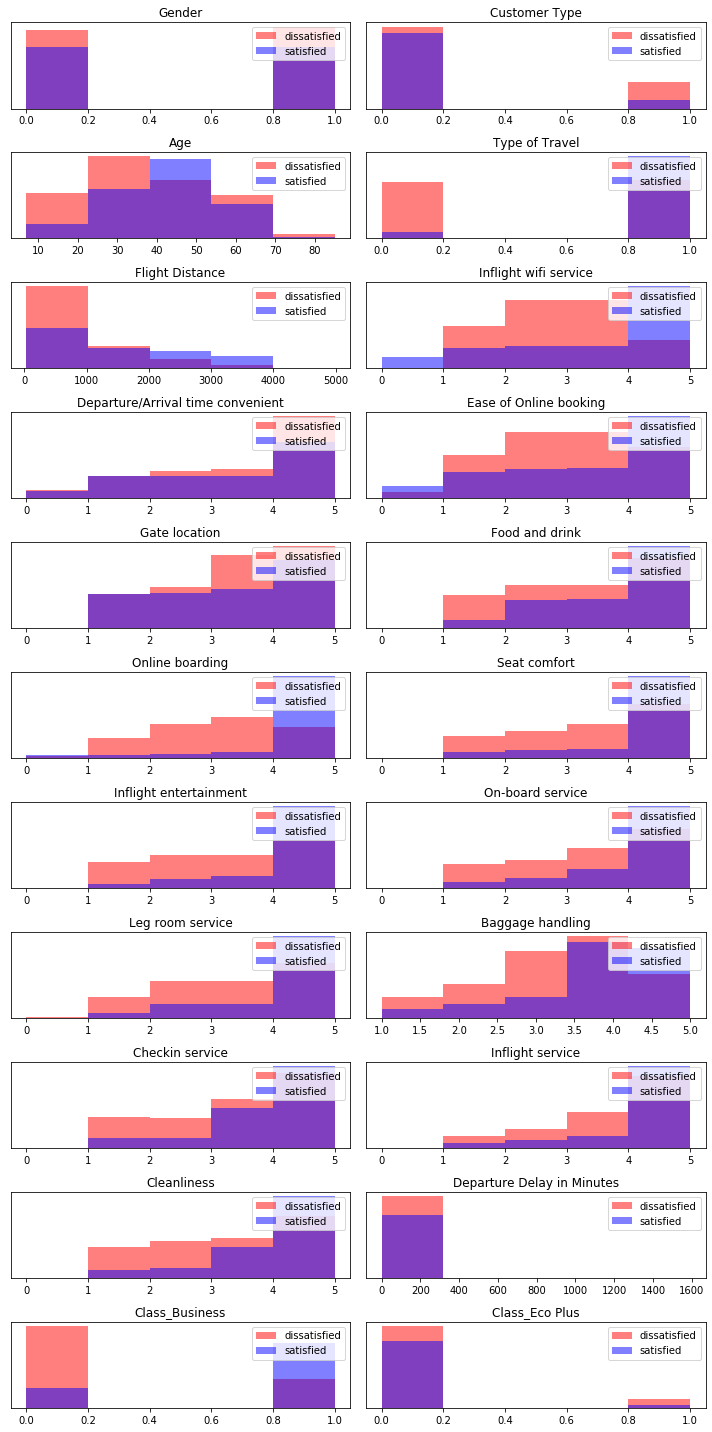

In [14]:
dissatisfied = df.loc[ df['satisfaction'] == 0, : ]
satisfied = df.loc[ df['satisfaction'] == 1, : ]

fig, axes = plt.subplots(11, 2, figsize=(10, 20))
ax = axes.ravel() # axes are 2-dimensional so we unfold them
for i in range(22):
    _, bins = np.histogram(df.iloc[:,i], bins=5) # bins 5 ili 50 ovisno koji graf želimo gledat
    ax[i].hist(dissatisfied.iloc[:,i], bins=bins, color='r', alpha=.5, label='dissatisfied')
    ax[i].hist(satisfied.iloc[:,i], bins=bins, color='b', alpha=.5, label='satisfied')
    ax[i].set_title(df.columns.values[i])
    ax[i].set_yticks(()) # remove ticks on y-axis
    ax[i].legend(loc='upper right')
fig.tight_layout()

Online boarding i class business se čine kao značajke kod koje su klase (dissatisfied i satisfied) najrazdvojenije.

## Odabir značajki

### Rekurzivna eliminacija značajki s unakrsnom validacijom - Random Forest

In [15]:
train, test = train_test_split(df, test_size=0.20, random_state=42)
X_train = train.drop('satisfaction',axis=1)
y_train = train['satisfaction']

rfecv = RFECV(RandomForestClassifier(n_estimators=100,random_state=0,n_jobs=-1), 
                 step=1, 
                 cv=StratifiedKFold(n_splits=2),
                 scoring='accuracy')
rfecv.fit(X_train, y_train);

In [16]:
print('Optimalni broj featurea: {}'.format(rfecv.n_features_))

Optimalni broj featurea: 18


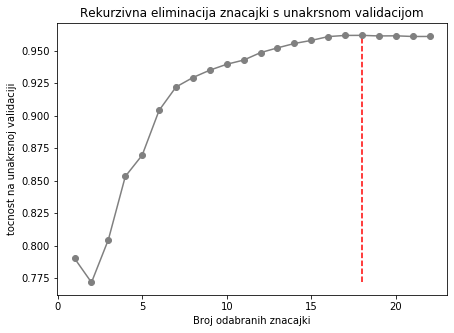

In [17]:
plt.figure(figsize=(7,5))

plt.plot(range(1, len(rfecv.grid_scores_) + 1), rfecv.grid_scores_, '-o',color='gray')
plt.xlabel('Broj odabranih znacajki')
plt.ylabel('tocnost na unakrsnoj validaciji')
plt.title('Rekurzivna eliminacija znacajki s unakrsnom validacijom')
plt.vlines(rfecv.n_features_, 
           np.min(rfecv.grid_scores_), 
           rfecv.grid_scores_[rfecv.n_features_-1], 
           color='red', linestyle='--')
plt.show()

In [18]:
print("Stupci za izbaciti: ", X_train.columns[np.where(rfecv.support_ == False)[0]])

Stupci za izbaciti:  Index(['Gender', 'Food and drink', 'Departure Delay in Minutes',
       'Class_Eco Plus'],
      dtype='object')


In [19]:
X_train.drop(X_train.columns[np.where(rfecv.support_ == False)[0]], axis=1, inplace=True)

Pokušajmo sada vizualizirati važnost preostalih featurea:

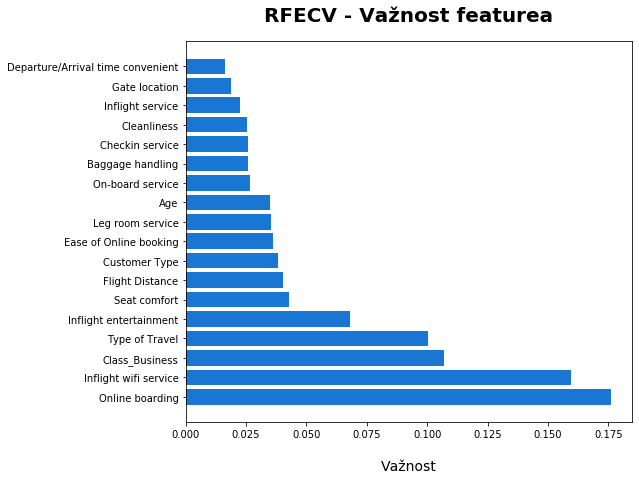

In [20]:
dset = pd.DataFrame()
dset['attr'] = X_train.columns
dset['importance'] = rfecv.estimator_.feature_importances_

dset = dset.sort_values(by='importance', ascending=False)


plt.figure(figsize=(8, 7))
plt.barh(y=dset['attr'], width=dset['importance'], color='#1976D2')
plt.title('RFECV - Važnost featurea', fontsize=20, fontweight='bold', pad=20)
plt.xlabel('Važnost', fontsize=14, labelpad=20)
plt.show()

Kao što vidimo, posljednja četri featurea imaju znatno veću važnost od ostalih, tako da model možemo pokušati konstruirati samo i sa ova četri stupca te vidjeti koliku točnost dobivamo. 

### Chi2

                     Specs         Score
8          Online boarding  14562.776630
17          Class_Business  13530.333730
10  Inflight entertainment   8760.811006
2           Type of Travel   6429.416114
9             Seat comfort   6380.660365
3    Inflight wifi service   5412.930489
11        On-board service   5320.310888
12        Leg room service   5224.078238
16             Cleanliness   5124.531783
1            Customer Type   2935.206653


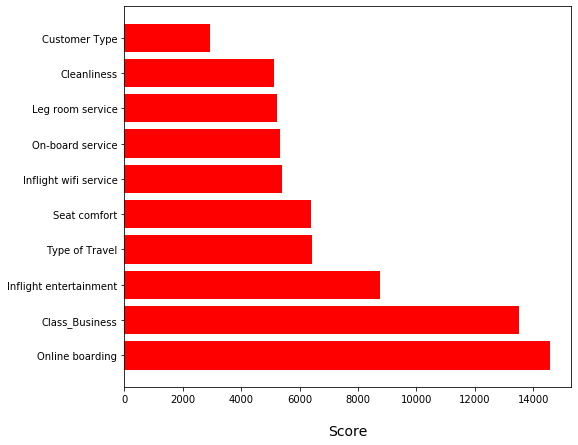

In [21]:
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2

train, test = train_test_split(df, test_size=0.20, random_state=42)

X_train = train.drop(['satisfaction', 'Age', 'Flight Distance', 'Departure Delay in Minutes'],axis=1)
y_train = train['satisfaction']

bestfeatures = SelectKBest(score_func=chi2, k=10)
fit = bestfeatures.fit(X_train,y_train)
dfscores = pd.DataFrame(fit.scores_)
dfcolumns = pd.DataFrame(X_train.columns)

featureScores = pd.concat([dfcolumns,dfscores],axis=1)
featureScores.columns = ['Specs','Score']  
print(featureScores.nlargest(10,'Score'))

plt.figure(figsize=(8, 7))
plt.barh(y=featureScores.nlargest(10,'Score')['Specs'], width=featureScores.nlargest(10,'Score')['Score'], color='red')
plt.xlabel('Score', fontsize=14, labelpad=20)
plt.show()

### Heatmap

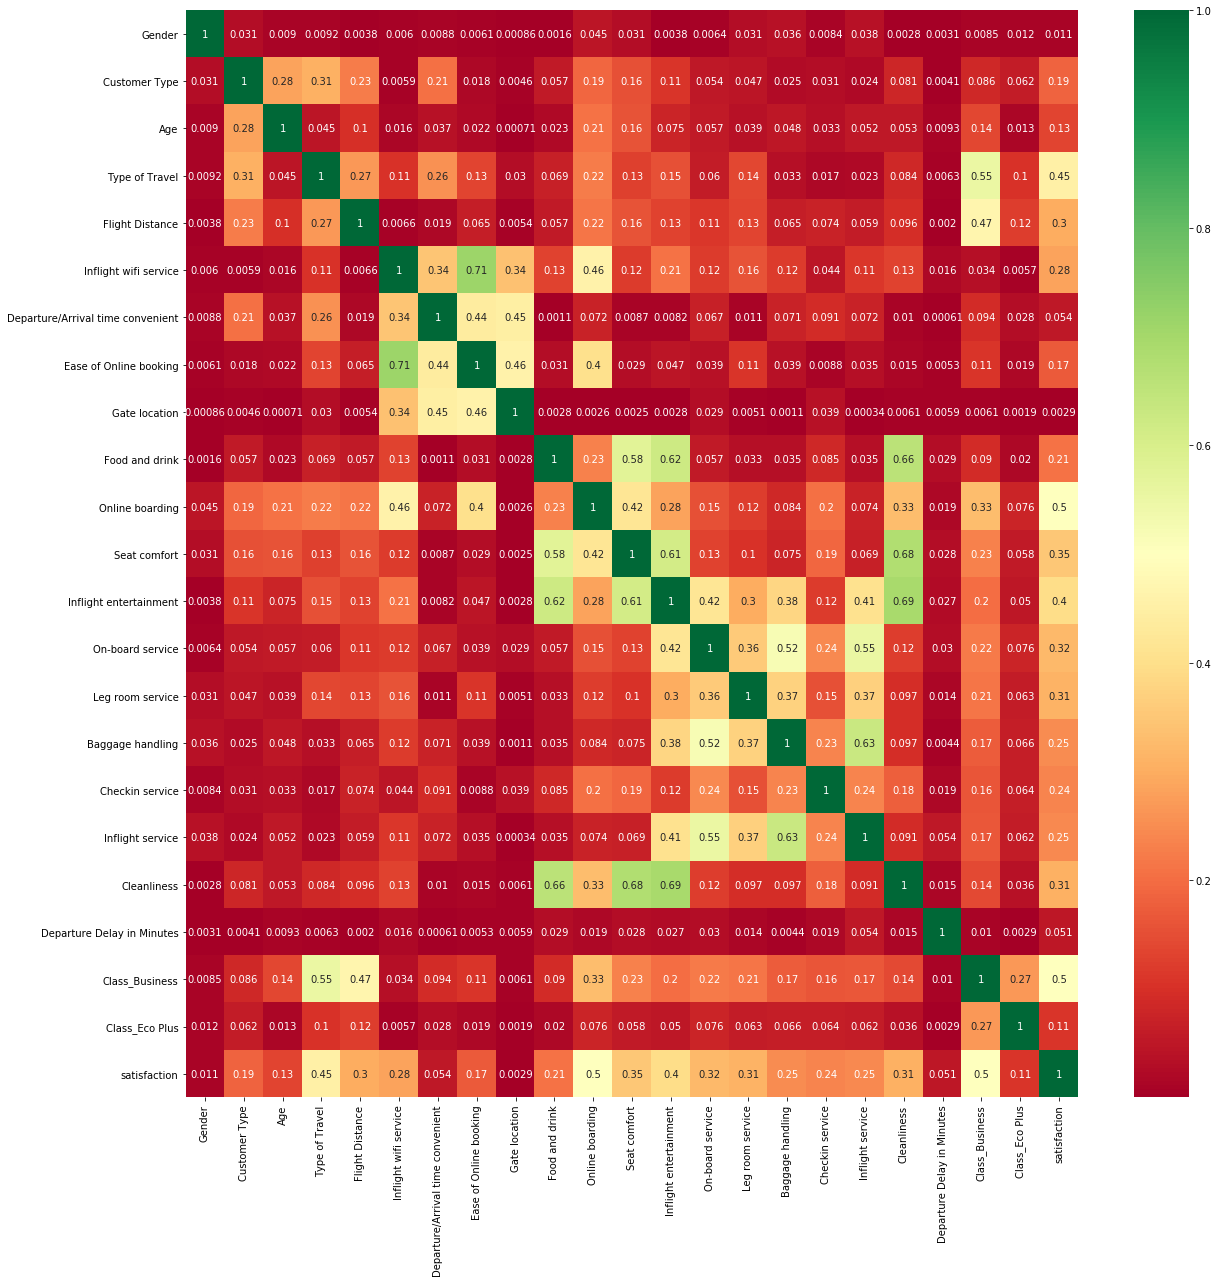

In [22]:
corrmat = df.corr()
top_corr_features = corrmat.index
plt.figure(figsize=(20,20))

g=sns.heatmap(abs(df[top_corr_features].corr()),annot=True,cmap="RdYlGn")

Iz heatmapa vidimo da je zadovoljstvo visoko korelirano s vrstom putovanja, online boardingom i s time radi li se o business klasi, dok je najslabije korelirana s lokacijom vrata i spolom putnika.

### Extra Trees Classifier

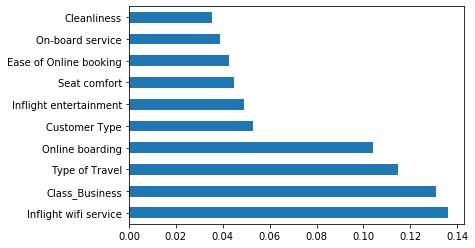

In [23]:
from sklearn.ensemble import ExtraTreesClassifier

train, test = train_test_split(df, test_size=0.20, random_state=42)
X_train = train.drop('satisfaction',axis=1)
y_train = train['satisfaction']

model = ExtraTreesClassifier()
model.fit(X_train,y_train)

feat_importances = pd.Series(model.feature_importances_, index=X_train.columns)
feat_importances.nlargest(10).plot(kind='barh')
plt.show()

### Logistic Regression

In [24]:
from sklearn.linear_model import LogisticRegression

train, test = train_test_split(df, test_size=0.20, random_state=42)
X_train = train.drop('satisfaction',axis=1)
y_train = train['satisfaction']

rfecv_lr = RFECV(LogisticRegression(solver='liblinear'), 
                 step=1, 
                 cv=StratifiedKFold(n_splits=2),
                 scoring='accuracy')
rfecv_lr.fit(X_train, y_train);

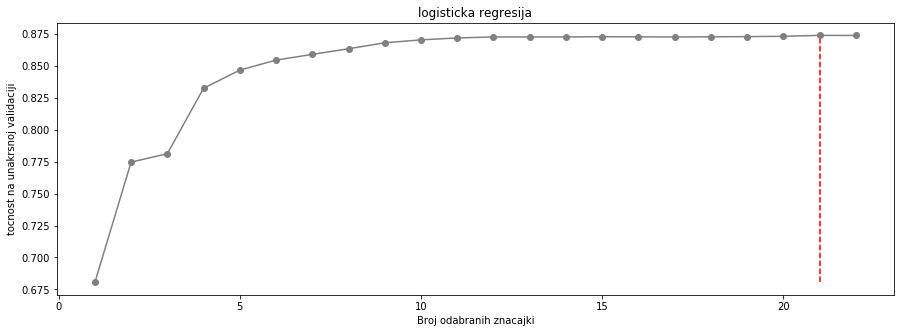

In [25]:
fig, ax = plt.subplots(1, figsize=(15, 5))

ax.plot(range(1, len(rfecv_lr.grid_scores_) + 1), rfecv_lr.grid_scores_, '-o', color='gray')
ax.set(xlabel='Broj odabranih znacajki',ylabel='tocnost na unakrsnoj validaciji',title='logisticka regresija')
ax.vlines(rfecv_lr.n_features_, 
             np.min(rfecv_lr.grid_scores_), 
             rfecv_lr.grid_scores_[rfecv_lr.n_features_-1], 
             color='red', linestyle='--')

plt.show()

In [26]:
print("Stupci za izbaciti: ", X_train.columns[np.where(rfecv_lr.support_ == False)[0]])

Stupci za izbaciti:  Index(['Flight Distance'], dtype='object')


### Mutual Information

In [27]:
from sklearn.feature_selection import mutual_info_classif

train, test = train_test_split(df, test_size=0.20, random_state=42)
X_train = train.drop('satisfaction',axis=1)
y_train = train['satisfaction']

info = mutual_info_classif(X_train, y_train, discrete_features=True)
dfscores = pd.DataFrame(info)
dfcolumns = pd.DataFrame(X_train.columns)

fs = pd.concat([dfcolumns,dfscores],axis=1)
fs.columns = ['Specs','Score']  
print(fs.nlargest(10,'Score'))

                     Specs     Score
10         Online boarding  0.210167
5    Inflight wifi service  0.163377
20          Class_Business  0.130991
3           Type of Travel  0.113067
12  Inflight entertainment  0.094225
4          Flight Distance  0.080697
11            Seat comfort  0.078252
14        Leg room service  0.060124
13        On-board service  0.057792
18             Cleanliness  0.052406


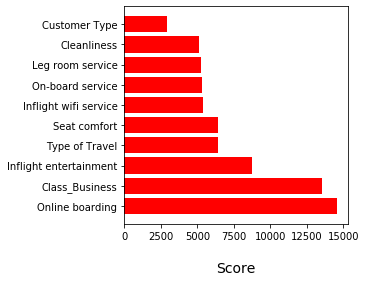

In [28]:
plt.figure(figsize=(4, 4))
plt.barh(y=featureScores.nlargest(10,'Score')['Specs'], width=featureScores.nlargest(10,'Score')['Score'], color='red')
plt.xlabel('Score', fontsize=14, labelpad=20)
plt.show()